# 蚁群算法Ant Colony Optimization

## 蚁群算法简介

蚂蚁在寻找食物的过程中，会在路径上释放信息素，其他蚂蚁可以感知这些信息素并倾向于选择信息素浓度高的路径，从而形成一种正反馈机制，最终找到从巢穴到食物源的最短路径。

蚁群算法是基于上述过程创建的离散优化算法

## 蚁群算法的基本原理


1. 信息素释放 ： 蚂蚁在路径上释放信息素

 什么是信息素？ 

 信息素是蚁群之间用于通信的化学物质，在蚁群中，信息素是一种数值，用来表示路径的吸引力和受欢迎程度，比如说当前的多只蚂蚁选择了某一条路径，那么这条路径上面的信息素就会增加，下一代中，新的蚂蚁就会更有可能选择这条路径

2. 路径选择 ： 蚂蚁根据路径上的信息素浓度和启发式信息选择下一步

 启发式信息 ：就是这个问题要优化的指标，根据每个问题本身，有不同的启发式信息，同时其具有局部特点，只考虑当前节点到下一节点的局部信息，不考虑全局

 例如 ；
*  TSP问题：η(i,j) = 1/d(i,j)，其中d(i,j)是城市i和j之间的距离
    距离越短，启发式值越大，蚂蚁选择近邻城市的概率越高
*  调度问题：η(i,j) = 1/t(i,j)，其中t(i,j)是任务i在j机器上的处理时间
    处理时间越短，启发式值越大
*  背包问题：η(i) = v(i)/w(i)，其中v是物品价值，w是物品重量
    单位重量价值越高，启发式值越大



3. 信息素更新 ： 路径上的信息素会随时间蒸发，并根据蚂蚁的路径质量增加

 信息素更新分为两部分，一个是信息素挥发，一个是信息素沉积

信息素挥发指的是所有路径上的信息素会随着时间逐渐减少
信息素沉积指的是蚂蚁会在其走过的路径上面沉积新的信息素，优质路径会获得更多的信息素增强


## 数学模型

蚁群算法中的概率计算公式用于模拟蚂蚁选择路径的行为，其核心在于结合信息素浓度和启发式信息，具体公式如下：



### 概率计算公式
对于蚂蚁 \( k \) 位于节点 \( i \) 时，选择移动到节点 \( j \) 的概率 \( P_k(i, j) \) 为：

$$P_k(i, j) = \frac{[\tau(i, j)]^\alpha \cdot [\eta(i, j)]^\beta}{\sum_{l \in \text{允许节点}} [\tau(i, l)]^\alpha \cdot [\eta(i, l)]^\beta}$$

其中：
- **$\tau(i, j)$** 是边$(i, j)$ 上的信息素浓度。
- **$ \eta(i, j) $** 是启发式信息，通常为路径的吸引力（如距离的倒数 $1/d_{ij} $）。
- **$ \alpha $** 和 **$ \beta $** 是超参数，分别控制信息素和启发式信息的重要性。
- **分母** 是对所有允许节点 $ l $ 的 $ [\tau(i, l)]^\alpha \cdot [\eta(i, l)]^\beta $ 求和，确保概率归一化。


### 信息素蒸发

信息素蒸发发生在所有路径上，通过降低信息素浓度避免算法陷入局部最优。其数学表达式为：
$$
\tau(i, j) \leftarrow (1 - \rho) \cdot \tau(i, j)
$$
其中：
- $\tau(i, j)$：边 $(i, j)$ 上的当前信息素浓度。
- $\rho$（蒸发率）：取值在[0, 1]之间的常数

蒸发率越高代表的信息保留程度就越低



## 代码实现

迭代 10/100, 当前最优距离: 633.95
迭代 20/100, 当前最优距离: 557.30
迭代 30/100, 当前最优距离: 557.30
迭代 40/100, 当前最优距离: 511.69
迭代 50/100, 当前最优距离: 494.53
迭代 60/100, 当前最优距离: 485.45
迭代 70/100, 当前最优距离: 484.20
迭代 80/100, 当前最优距离: 480.06
迭代 90/100, 当前最优距离: 461.72
迭代 100/100, 当前最优距离: 461.72
优化完成，耗时: 1.44秒

优化结果:
最优路径: [28, 29, 20, 13, 8, 23, 22, 3, 21, 16, 5, 0, 12, 4, 27, 26, 17, 25, 1, 19, 6, 14, 10, 15, 24, 9, 11, 7, 18, 2]
最优距离: 461.72


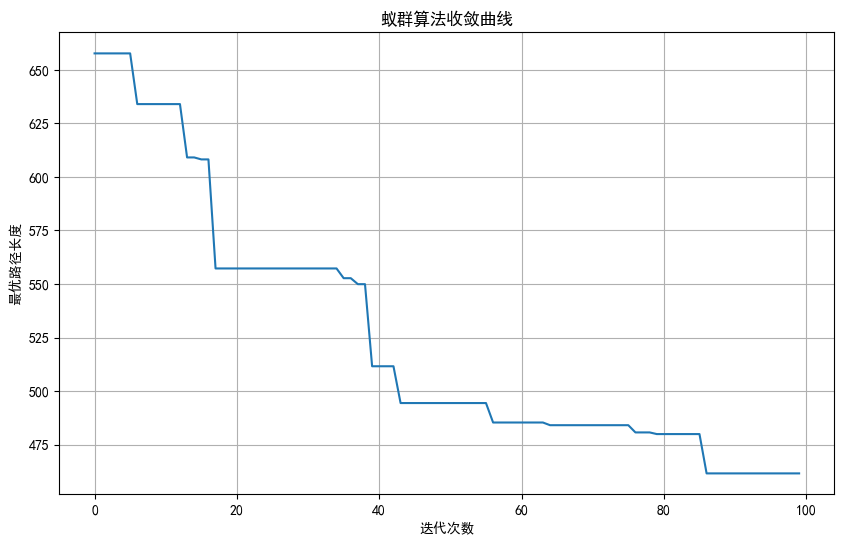

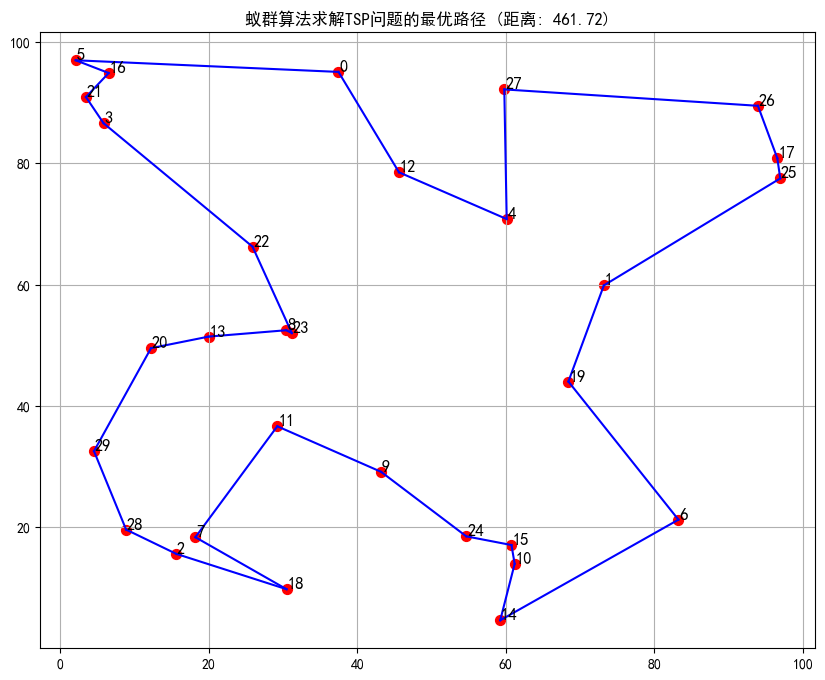

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

class AntColonyOptimization:
    def __init__(self, distances, n_ants=10, decay=0.1, alpha=1.0, beta=2.0, q=1.0, iterations=100):
        """
        初始化蚁群算法
        
        参数:
            distances: 城市间距离矩阵
            n_ants: 蚂蚁数量
            decay: 信息素蒸发率
            alpha: 信息素重要性参数
            beta: 启发式信息重要性参数
            q: 信息素释放总量
            iterations: 迭代次数
        """
        self.distances = distances
        self.n_cities = distances.shape[0]
        self.n_ants = n_ants
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.q = q
        self.iterations = iterations
        
        # 初始化信息素矩阵
        self.pheromone = np.ones((self.n_cities, self.n_cities))
        
        # 计算启发式信息矩阵（距离的倒数）
        self.heuristic = 1.0 / (distances + 1e-10)  # 添加小值避免除零
        
        # 记录最优解
        self.best_path = None
        self.best_distance = float('inf')
        
        # 记录每次迭代的最优距离
        self.best_distance_history = []
    
    def run(self):
        """运行蚁群算法"""
        start_time = time.time()
        
        for iteration in range(self.iterations):
            # 每只蚂蚁构建路径
            all_paths = self.construct_paths()
            
            # 计算每条路径的长度
            distances = self.calculate_path_distances(all_paths)
            
            # 更新当前迭代的最优解
            iteration_best_idx = np.argmin(distances)
            iteration_best_path = all_paths[iteration_best_idx]
            iteration_best_distance = distances[iteration_best_idx]
            
            # 更新全局最优解
            if iteration_best_distance < self.best_distance:
                self.best_distance = iteration_best_distance
                self.best_path = iteration_best_path.copy()
            
            # 记录历史
            self.best_distance_history.append(self.best_distance)
            
            # 更新信息素
            self.update_pheromone(all_paths, distances)
            
            # 每10次迭代打印一次进度
            if (iteration + 1) % 10 == 0:
                print(f"迭代 {iteration + 1}/{self.iterations}, 当前最优距离: {self.best_distance:.2f}")
        
        end_time = time.time()
        print(f"优化完成，耗时: {end_time - start_time:.2f}秒")
        
        return self.best_path, self.best_distance
    
    def construct_paths(self):
        """每只蚂蚁构建完整路径"""
        all_paths = []
        
        for ant in range(self.n_ants):
            # 随机选择起始城市
            current_city = np.random.randint(self.n_cities)
            path = [current_city]
            unvisited = list(range(self.n_cities))
            unvisited.remove(current_city)
            
            # 构建完整路径
            while unvisited:
                next_city = self.choose_next_city(current_city, unvisited)
                path.append(next_city)
                unvisited.remove(next_city)
                current_city = next_city
            
            all_paths.append(path)
        
        return all_paths
    
    def choose_next_city(self, current_city, unvisited):
        """根据概率选择下一个城市"""
        # 计算转移概率
        pheromone = np.array([self.pheromone[current_city, j] for j in unvisited])
        heuristic = np.array([self.heuristic[current_city, j] for j in unvisited])
        
        probabilities = (pheromone ** self.alpha) * (heuristic ** self.beta)
        probabilities = probabilities / np.sum(probabilities)
        
        # 轮盘赌选择
        selected = np.random.choice(len(unvisited), p=probabilities)
        return unvisited[selected]
    
    def calculate_path_distances(self, all_paths):
        """计算所有路径的总距离"""
        distances = np.zeros(self.n_ants)
        
        for i, path in enumerate(all_paths):
            distance = 0
            for j in range(len(path) - 1):
                distance += self.distances[path[j], path[j+1]]
            # 添加回到起点的距离
            distance += self.distances[path[-1], path[0]]
            distances[i] = distance
        
        return distances
    
    def update_pheromone(self, all_paths, distances):
        """更新信息素矩阵"""
        # 信息素蒸发
        self.pheromone *= (1 - self.decay)
        
        # 信息素增强
        for ant, path in enumerate(all_paths):
            # 计算这只蚂蚁释放的信息素量
            delta = self.q / distances[ant]
            
            # 在路径上增加信息素
            for i in range(len(path) - 1):
                self.pheromone[path[i], path[i+1]] += delta
                self.pheromone[path[i+1], path[i]] += delta  # 对称更新
            
            # 处理回到起点的路径
            self.pheromone[path[-1], path[0]] += delta
            self.pheromone[path[0], path[-1]] += delta
    
    def plot_convergence(self):
        """绘制收敛曲线"""
        plt.figure(figsize=(10, 6))
        
        # 设置中文字体
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
        plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
        
        plt.plot(self.best_distance_history)
        plt.title('蚁群算法收敛曲线')
        plt.xlabel('迭代次数')
        plt.ylabel('最优路径长度')
        plt.grid(True)
        plt.show()
    
    def plot_best_path(self, city_coordinates):
        """绘制最优路径"""
        if self.best_path is None:
            print("请先运行算法")
            return
        
        plt.figure(figsize=(10, 8))
        
        # 设置中文字体
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
        plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
        
        # 绘制城市点
        x = [city_coordinates[i][0] for i in range(self.n_cities)]
        y = [city_coordinates[i][1] for i in range(self.n_cities)]
        plt.scatter(x, y, c='red', s=50)
        
        # 标记城市编号
        for i in range(self.n_cities):
            plt.text(x[i] + 0.1, y[i] + 0.1, str(i), fontsize=12)
        
        # 绘制最优路径
        for i in range(len(self.best_path) - 1):
            city1 = self.best_path[i]
            city2 = self.best_path[i + 1]
            plt.plot([x[city1], x[city2]], [y[city1], y[city2]], 'b-')
        
        # 连接最后一个城市和第一个城市
        plt.plot([x[self.best_path[-1]], x[self.best_path[0]]], 
                 [y[self.best_path[-1]], y[self.best_path[0]]], 'b-')
        
        plt.title(f'蚁群算法求解TSP问题的最优路径 (距离: {self.best_distance:.2f})')
        plt.grid(True)
        plt.show()

# 生成随机TSP问题
def generate_random_tsp(n_cities, seed=None):
    """生成随机TSP问题"""
    if seed is not None:
        np.random.seed(seed)
    
    # 生成随机城市坐标
    city_coordinates = np.random.rand(n_cities, 2) * 100
    
    # 计算城市间距离矩阵
    distances = np.zeros((n_cities, n_cities))
    for i in range(n_cities):
        for j in range(n_cities):
            if i != j:
                # 欧几里得距离
                distances[i, j] = np.sqrt(np.sum((city_coordinates[i] - city_coordinates[j]) ** 2))
    
    return distances, city_coordinates

# 主函数
if __name__ == "__main__":
    # 生成随机TSP问题 (30个城市)
    n_cities = 30
    distances, city_coordinates = generate_random_tsp(n_cities, seed=42)
    
    # 创建ACO优化器
    aco = AntColonyOptimization(
        distances=distances,
        n_ants=30,         # 蚂蚁数量通常设置为城市数量
        decay=0.1,         # 信息素蒸发率
        alpha=1.0,         # 信息素重要性
        beta=2.0,          # 启发式信息重要性
        q=1.0,             # 信息素释放总量
        iterations=100     # 迭代次数
    )
    
    # 运行算法
    best_path, best_distance = aco.run()
    
    # 输出结果
    print("\n优化结果:")
    print(f"最优路径: {best_path}")
    print(f"最优距离: {best_distance:.2f}")
    
    # 绘制收敛曲线
    aco.plot_convergence()
    
    # 绘制最优路径
    aco.plot_best_path(city_coordinates)